
# Movie Recommender System with NCF Variants

## Overview
In this project, we explore four different Neural Collaborative Filtering (NCF) architectures to build a movie recommendation system. The models incorporate user–item interactions through deep learning techniques and utilize additional movie features to enhance prediction quality.

### 1. NCF with MLP for Continuous and Binary Ratings Prediction
#### Approach:
The first approach consists of **two separate NCF models** designed to handle:
1. **Continuous Ratings Prediction**: Predicting user ratings on a scale (e.g., from 1 to 5).
2. **Binary Ratings Prediction**: Classifying whether a user liked or disliked a movie.

The architecture uses a **basic neural collaborative filtering (NCF)** approach where:
- User–item interactions are modeled using a **multi-layer perceptron (MLP)**.
- User and item embeddings are concatenated and passed through multiple fully connected layers.
- This enables the model to learn complex, non-linear relationships between users and items.

#### Why We Use It:
The dual model setup is beneficial because:
- **Continuous Ratings Prediction**: Captures nuanced differences in user preferences.
- **Binary Ratings Prediction**: Focuses on recommending items that a user is likely to enjoy.
- The separation allows for fine-tuning each model for its specific task.

#### How It Is Implemented:
- User and item embeddings are learned using the `nn.Embedding` layer.
- The embeddings are concatenated and passed through multiple dense layers with activation functions.
- The final output layer predicts either the rating (regression) or the probability of a positive rating (binary classification).
- The model for continuous ratings is trained using **Mean Squared Error (MSE) Loss**, while the binary model uses **Binary Cross-Entropy (BCE) Loss**.

---

### 2. NeuMF with MLP and GMF
#### Approach:
NeuMF (Neural Matrix Factorization) combines:
- **Generalized Matrix Factorization (GMF)**: A linear interaction model where user and item embeddings are multiplied element-wise.
- **Multi-Layer Perceptron (MLP)**: Captures non-linear user–item interactions.
- The outputs of GMF and MLP are **fused** before making a final prediction.

#### Why We Use It:
- The combination of GMF and MLP allows the model to capture both **linear and non-linear** user–item interaction patterns.
- It leverages the strengths of both models: the interpretability of GMF and the expressiveness of MLP.
- NeuMF is suitable for both continuous and binary rating predictions.

#### How It Is Implemented:
- The user and item embeddings are **shared** between GMF and MLP branches.
- The GMF branch directly computes the element-wise product of the embeddings.
- The MLP branch concatenates the embeddings and passes them through dense layers.
- The outputs from both branches are combined through a fusion layer and passed through a final dense layer.
- The model is trained using **MSE Loss**.

---

### 3. Hybrid NCF with Movie Features via Concatenation
#### Approach:
Incorporates **additional movie features** (such as textual representations, release year, runtime category, popularity, and voting statistics) into the NCF framework.
- These movie features are concatenated with user and item embeddings.
- The fused representation is then passed through MLP layers.

#### Why We Use It:
- Adding movie features enhances the model's ability to capture **content-based aspects** along with collaborative filtering.
- Helps address the **cold-start problem**, especially when user interaction data is sparse.

#### How It Is Implemented:
- The movie features are processed through a **fully connected layer** to reduce dimensionality.
- The transformed features are concatenated with user and item embeddings.
- The combined vector is passed through several dense layers to learn the interaction.
- The final layer outputs the predicted rating or probability.
- The model is trained using **MSE Loss** for continuous ratings and **BCE Loss** for binary ratings.

---

### 4. Hybrid NeuMF with Movie Features via Gated Fusion
#### Approach:
Instead of simple concatenation, this model utilizes a **gated fusion mechanism** to combine the GMF and MLP outputs with the movie features.
- A **gating network** learns to balance the contributions of the collaborative filtering (CF) part and the movie feature part dynamically.

#### Why We Use It:
- Simple concatenation may not fully capture the **complex interactions** between CF embeddings and movie features.
- Gated fusion allows the model to **learn adaptive weighting**, which can lead to better performance in scenarios where certain features are more informative.
- This approach is particularly useful when movie features have varying levels of relevance for different users.

#### How It Is Implemented:
- The outputs from GMF, MLP, and movie feature layers are combined through a **gating network**.
- The gating network generates a **weight vector** that modulates the contribution of each component.
- The fused representation is passed through a final output layer.
- The model is trained using **BCE Loss** for binary classification or **MSE Loss** for regression.

---

## Model Evaluation
For each model, we evaluate the performance using the following metrics:
- **Accuracy**: Measures how often the model correctly predicts the user’s rating.
- **Precision@K**: Proportion of recommended items in the top-K that are relevant.
- **Recall@K**: Proportion of relevant items recommended in the top-K.
- **F1@K**: Harmonic mean of Precision and Recall.
- **NDCG@K**: Normalized Discounted Cumulative Gain, which accounts for the ranking of the relevant items.

### Top-K Recommendations and Ground Truth Comparison
After training, each model generates **top-K recommendations** for randomly selected users from the test set. We then compare the recommendations with the **ground truth** to assess the quality of the model. This comparison helps to evaluate whether the model's recommendations align with the actual preferences expressed by users.

---

## Summary
By comparing four models—**basic NCF with MLP for continuous and binary ratings**, **NeuMF with GMF and MLP**, **Hybrid NCF with Concatenation**, and **Hybrid NeuMF with Gated Fusion**—we aim to understand the impact of incorporating movie features and the difference between **simple concatenation** and **gated fusion**. This comprehensive approach allows us to leverage both **collaborative filtering** and **content-based features**, resulting in a more robust recommendation system.

## Import Libraries ##

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
import gdown
import ast
from pandas.api.types import is_list_like
from transformers import BertTokenizer, BertModel

## For Reproducibility ##

In [ ]:
torch.manual_seed(69)
np.random.seed(69)

## Load Data ##

In [ ]:
#### PROCESSED RATING DATA #####
ratings_df_ncf = pd.read_csv("processed_ratings.csv")

##### MOVIES AND FEATURES COMBINED DATA ####
df_movies_and_keywords = pd.read_csv("movies_and_keywords.csv")

In [ ]:
df_movies_and_keywords.head()

,adult,genres,id,original_language,original_title,overview,production_countries,spoken_languages,release_year,runtime_category,vote_count_log,vote_average_norm,vote_count_norm,popularity_norm,years_since_release,keyword_values,textual_representation
0,False,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",United States of America,English,1995,Medium,8.597113,0.77,0.900011,0.040087,22,"jealousy, toy, boy, friendship, friends, rival...","This movie is titled Toy Story, produced in Un..."
1,False,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,United States of America,"English, Français",1995,Medium,7.789040,0.69,0.815416,0.031079,22,"board game, disappearance, based on children's...","This movie is titled Jumanji, produced in Unit..."
2,False,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,United States of America,English,1995,Medium,4.532599,0.65,0.474507,0.021394,22,"fishing, best friend, duringcreditsstinger, ol...","This movie is titled Grumpier Old Men, produce..."
3,False,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",United States of America,English,1995,Long,3.555348,0.61,0.372201,0.007049,22,"based on novel, interracial relationship, sing...","This movie is titled Waiting to Exhale, produc..."
4,False,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,United States of America,English,1995,Medium,5.159055,0.57,0.540089,0.015320,22,"baby, midlife crisis, confidence, aging, daugh...",This movie is titled Father of the Bride Part ...


In [ ]:
ratings_df_ncf.head()

,userId,movieId,rating,date_time
0,1,1371,2.5,2009-12-14 02:52:15
1,1,1405,1.0,2009-12-14 02:53:23
2,1,2105,4.0,2009-12-14 02:52:19
3,1,2193,2.0,2009-12-14 02:53:18
4,1,2294,2.0,2009-12-14 02:51:48


# 1. Data Preparation

### BERT Embedding of Textual Representation

To incorporate movie textual features, we use **BERT embeddings** to transform the `textual_representation` column into numerical vectors. We utilize the `all-MiniLM-L6-v2` model from the **Sentence Transformers** library due to its efficiency and high performance on sentence embedding tasks.

The embeddings capture the **semantic meaning** of the textual descriptions, allowing the model to leverage textual information during training. The resulting embeddings have a shape of **384 dimensions** and are stored in the `bert_embedding` column.

In [ ]:
from sentence_transformers import SentenceTransformer

# Initialize a pre-trained model. 'all-MiniLM-L6-v2' is a good lightweight model.
model = SentenceTransformer('all-MiniLM-L6-v2')

# Get a list of texts from your DataFrame
texts = df_movies_and_keywords['textual_representation'].tolist()

# Encode all texts in batches (you can adjust batch_size if needed)
embeddings = model.encode(texts, show_progress_bar=True, batch_size=32)

# Add the embeddings back to your DataFrame
df_movies_and_keywords['bert_embedding'] = list(embeddings)

# Check the shape of Embedding
print("Embedding shape:", df_movies_and_keywords['bert_embedding'].iloc[0].shape)

Batches:   0%|          | 0/1410 [00:00<?, ?it/s]

Embedding shape: (384,)


# 2. Model Evaluation

## 2.1 Evaluation Metrics

To assess the performance of our recommendation models, we employ several evaluation metrics, which are computed for each user and averaged over all users. The following metrics are calculated:

1. **Precision@K**: Measures the proportion of recommended items in the top-K list that are relevant. A high precision indicates that the recommended items are of high quality.

2. **Recall@K**: Measures the proportion of relevant items that are recommended in the top-K list. A high recall indicates that most relevant items are being recommended.

3. **F1@K**: Harmonic mean of Precision@K and Recall@K, balancing both metrics.

4. **Hit Rate@K**: Checks if at least one relevant item appears in the top-K list. A high hit rate indicates that the model often includes at least one relevant item.

5. **NDCG@K (Normalized Discounted Cumulative Gain)**: Evaluates the ranking quality by taking the position of the relevant items into account. A high NDCG indicates that relevant items are ranked higher.

#### Use of Actual K
In the code, the value of **K** is dynamically adjusted based on the number of items available for each user. Specifically:
- The code calculates **actual_k** as the minimum of the predefined K value and the number of items for the user.
- This adjustment ensures that the evaluation metrics are not skewed when the number of available items is less than K.
- This is crucial when users have interacted with fewer items than K, as it avoids overestimating precision and recall.

#### Implementation Details:
- Binarize relevance based on a threshold (e.g., rating >= 4).
- Sort items based on predicted scores and select the top-actual_k items.
- Calculate metrics for each user:
  - **Precision** is the fraction of recommended items that are relevant.
  - **Recall** is the fraction of relevant items that are recommended.
  - **F1 Score** combines Precision and Recall.
  - **Hit Rate** checks for the presence of at least one relevant item.
  - **NDCG** considers the ranking order of the relevant items.
- Return the average metrics across all users.

By using these metrics and dynamically adjusting K, we ensure a comprehensive evaluation that balances the quality, completeness, and ranking of recommendations, even for users with limited interaction data.

In [ ]:
def evaluate_recommendations(user_ids, preds, labels, k=10, threshold=4):
    """
    Computes recommendation metrics (Precision, Recall, F1, Hit Rate, NDCG) averaged over users.

    Parameters:
      user_ids: numpy array of user IDs corresponding to each prediction.
      preds: numpy array of predicted scores.
      labels: numpy array of true rating values.
      k: cutoff for top-k recommendations.
      threshold: threshold to decide if an item is relevant (e.g., rating >= 4).

    Returns:
      A tuple (precision, recall, f1, hit_rate, ndcg) averaged over users.
    """
    unique_users = np.unique(user_ids)
    precisions = []
    recalls = []
    f1s = []
    hit_rates = []
    ndcgs = []

    for u in unique_users:
        # Get indices for this user
        idx = (user_ids == u)
        user_preds = preds[idx]
        user_labels = labels[idx]

        # Binarize relevance
        binary_labels = (user_labels >= threshold).astype(int)

        # Sort items by predicted score in descending order
        sorted_idx = np.argsort(-user_preds)

        # Use actual_k = min(k, number of items for this user)
        actual_k = min(k, len(user_preds))
        top_k_idx = sorted_idx[:actual_k]

        # Compute precision and recall for top actual_k recommendations
        num_correct = np.sum((user_preds[top_k_idx] >= threshold).astype(int))
        precision = num_correct / k  # We divide by k to standardize (could also use actual_k)
        total_relevant = np.sum(binary_labels)
        recall = num_correct / total_relevant if total_relevant > 0 else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
        hit_rate = 1 if num_correct > 0 else 0

        # NDCG: use actual_k to compute discount factors
        sorted_labels = user_labels[sorted_idx][:actual_k]
        dcg = np.sum((2 ** sorted_labels - 1) / np.log2(np.arange(2, actual_k + 2)))
        ideal_labels = np.sort(user_labels)[::-1][:actual_k]
        idcg = np.sum((2 ** ideal_labels - 1) / np.log2(np.arange(2, actual_k + 2)))
        ndcg = dcg / idcg if idcg > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        hit_rates.append(hit_rate)
        ndcgs.append(ndcg)

    return (np.mean(precisions), np.mean(recalls), np.mean(f1s), np.mean(hit_rates), np.mean(ndcgs))

## 2.2 Model Evaluation

The evaluation of our recommendation models focuses on measuring both prediction accuracy and recommendation quality. We use the following metrics:

### Loss
- **Loss:** Calculated as the average loss over all samples.
  - For regression tasks, we use **Mean Squared Error (MSE) Loss**.
  - For binary classification tasks, we use **Binary Cross-Entropy (BCE) Loss**.

### Accuracy
- For **regression tasks**, a prediction is considered accurate if it exceeds a threshold (e.g., ≥4).
- For **binary tasks**, the threshold for relevance is set to 0.5.
- Accuracy is calculated as the proportion of correct predictions out of the total predictions.

### Implementation Summary
- The model is evaluated using the test data loader.
- Predictions are generated for each user-item pair.
- Metrics are computed using the `evaluate_recommendations` function, which aggregates the metrics across all users.


In [ ]:
def evaluate_model(model, data_loader, device, k=10, threshold=4, task="regression"):

    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []
    all_users = []

    # Use MSELoss for regression; for binary, you might normally use BCELoss
    # but here we assume the model outputs probabilities after sigmoid if task=="binary"
    if task == "regression":
        criterion = nn.MSELoss(reduction='sum')
    else:  # binary
        criterion = nn.BCELoss(reduction='sum')

    with torch.no_grad():
        for users, items, labels in data_loader:
            users, items, labels = users.to(device), items.to(device), labels.to(device)
            outputs = model(users, items)
            if task == "binary":
                # Apply sigmoid for binary task if not applied inside the model.
                outputs = torch.sigmoid(outputs)
            batch_size = users.size(0)
            total_samples += batch_size
            total_loss += criterion(outputs, labels).item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_users.extend(users.cpu().numpy())

    loss_avg = total_loss / total_samples
    rmse = np.sqrt(loss_avg)

    # Compute binary accuracy
    if task == "regression":
        bin_preds = (np.array(all_preds) >= threshold).astype(int)
        bin_labels = (np.array(all_labels) >= threshold).astype(int)
    else:  # binary task
        bin_preds = (np.array(all_preds) >= 0.5).astype(int)
        bin_labels = np.array(all_labels).astype(int)

    overall_acc = np.mean(bin_preds == bin_labels)

    precision, recall, f1, hit_rate, ndcg = evaluate_recommendations(
        np.array(all_users), np.array(all_preds), np.array(all_labels), k=k, threshold=threshold
    )

    metrics = {
        'loss': loss_avg,
        'rmse': rmse,
        'accuracy': overall_acc,
        'precision@k': precision,
        'recall@k': recall,
        'f1@k': f1,
        'hit_rate@k': hit_rate,
        'ndcg@k': ndcg
    }
    return metrics

## 2.2 Recommendations Vs Ground Truth - Test Set Interaction

In this section, we generate the top-K movie recommendations for selected users and compare them against the ground truth (i.e., the movies that the users have actually rated in the test set). This comparison allows us to visually inspect the quality of the recommendations.

### Generating Recommendations
We generate the top-K recommendations using the trained model. The function `recommend_top_k`:
- Takes the model, user ID, device, movie metadata, full ratings data, training data, and the number of recommendations (N) as inputs.
- Retrieves all possible items from the full catalog to form the candidate pool.
- Filters out items that the user has already interacted with in the training set.
- Uses the model to predict scores for the remaining candidate items.
- Selects the top-N items based on the predicted scores.
- Converts encoded movie IDs back to their original IDs and looks up the movie titles.
- Returns a list of top-N recommendations.

### Extracting Ground Truth
The function `get_ground_truth_titles`:
- Takes the user ID, test set, movie metadata, and the item encoder as inputs.
- Retrieves the list of items the user has interacted with in the test set.
- Converts encoded movie IDs back to their original IDs and looks up the movie titles.
- Returns the list of ground truth movie titles.

### Purpose
By comparing the recommended movie titles with the ground truth movies from the test set, we can assess whether the model's top predictions align with the movies the user has actually interacted with. This qualitative evaluation complements the quantitative metrics discussed earlier, giving insights into the practical relevance of the model’s recommendations.

In [ ]:
def recommend_top_k(model, user_id, device, df_movies_metadata, full_ratings_df, df_train, N=10, item_encoder=None):
    """
    Generate top-N recommendations for a given user.

    Parameters:
      model: The trained recommendation model.
      user_id: The user ID (encoded) for which to generate recommendations.
      device: The torch device.
      df_movies_metadata: DataFrame containing movie metadata with 'id' and 'original_title'.
      full_ratings_df: DataFrame containing all ratings (full catalog for candidate pool).
      df_train: DataFrame containing training interactions (to filter out known items).
      N: Number of recommendations.
      item_encoder: The LabelEncoder used to encode movie IDs.

    Returns:
      A list of tuples: (original_movie_id, movie_title, score)
    """
    import numpy as np
    # Candidate pool: all unique movie IDs from the full dataset.
    encoded_items = np.sort(full_ratings_df['item'].unique())

    # Known items: items the user interacted with in training.
    known_items = df_train[df_train['user'] == user_id]['item'].unique()

    candidate_items = encoded_items.tolist()

    # Create tensors.
    user_tensor = torch.tensor([user_id] * len(candidate_items), dtype=torch.long).to(device)
    item_tensor = torch.tensor(candidate_items, dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        scores = model(user_tensor, item_tensor).cpu().numpy()

    # Filter out known items.
    recs = [(item, score) for item, score in zip(candidate_items, scores) if item not in known_items]

    # Sort by score and take top N.
    top_recs = sorted(recs, key=lambda x: x[1], reverse=True)[:N]

    # Convert encoded IDs back to original and look up titles.
    recommendations = []
    for encoded_item, score in top_recs:
        original_movie_id = item_encoder.inverse_transform([encoded_item])[0]
        row = df_movies_metadata[df_movies_metadata['id'] == original_movie_id]
        title = row.iloc[0]['original_title'] if not row.empty else "Unknown Title"
        recommendations.append((original_movie_id, title, score))

    return recommendations
def get_ground_truth_titles(user, df_test, df_movies_metadata, item_encoder):
    """
    Get the ground truth movie titles for a given user based on test interactions.

    Parameters:
      user: The user ID (encoded).
      df_test: DataFrame containing test interactions with columns 'user' and 'item'.
      df_movies_metadata: DataFrame containing movie metadata with columns 'id' and 'original_title'.
      item_encoder: The LabelEncoder for movie IDs.

    Returns:
      A list of movie titles (ground truth) for that user.
    """
    # Ground truth: items in the test set for this user.
    gt_encoded = df_test[df_test['user'] == user]['item'].unique().tolist()
    gt_titles = []
    for enc in gt_encoded:
        original_movie_id = item_encoder.inverse_transform([enc])[0]
        row = df_movies_metadata[df_movies_metadata['id'] == original_movie_id]
        title = row.iloc[0]['original_title'] if not row.empty else "Unknown Title"
        gt_titles.append(title)
    return gt_titles

# 3. Simple NCF with MLP Predicting Continuous and Binary Ratings ##
This approach uses a basic neural collaborative filtering architecture where the user–item interactions are modeled via a multi-layer perceptron (MLP). Key details include:

<b> Embedding Layers: </b>
Each user and item is mapped to a dense vector space using embeddings, capturing latent features.

<b> MLP Layers: </b>
The user and item embeddings are concatenated and fed into a series of fully connected layers with non-linear activations. This learns complex, non-linear interactions between users and items.

<b> Output Predictions: </b>
- For continuous rating prediction (regression), the network directly outputs a continuous value (e.g., predicted rating) using a linear output neuron.
- For binary rating prediction (classification), the output is interpreted as a probability (after applying a sigmoid) to indicate positive (liked) or negative (not liked) user feedback.

<b> Training Strategy: </b>
Loss functions such as Mean Squared Error (MSE) for regression or Binary Cross-Entropy (BCE) for classification are used, with the model trained end-to-end to minimize prediction error.


## 3.1 Data Preparation ##

### Label Encoding ###
We load the ratings_small.csv dataset (MovieLens 100k subset), which contains user-item interactions in the form of ratings (from 1 to 5). These are considered explicit feedback.

Next, we perform the following preprocessing steps:
1. <b> Label Encoding: </b>
   Convert userId and movieId into consecutive integers to serve as indices in embedding layers.
3. <b> Create Two Types of Labels: </b>
   - label: Original rating, used for regression tasks.
   - label_binary: Binarized label for classification — 1 if rating ≥ 4, else 0.

In [ ]:
# Create and fit the encoders
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Encode userId and movieId into integer indices
ratings_df_ncf['user'] = user_encoder.fit_transform(ratings_df_ncf['userId'])
ratings_df_ncf['item'] = item_encoder.fit_transform(ratings_df_ncf['movieId'])

# Create regression labels (actual ratings) and binary labels (like/dislike)
ratings_df_ncf['label'] = ratings_df_ncf['rating']
ratings_df_ncf['label_binary'] = ratings_df_ncf['rating'].apply(lambda x: 1 if x >= 4 else 0)

In [ ]:
ratings_df_ncf.head()

,userId,movieId,rating,date_time,user,item,label,label_binary
0,1,1371,2.5,2009-12-14 02:52:15,0,704,2.5,0
1,1,1405,1.0,2009-12-14 02:53:23,0,725,1.0,0
2,1,2105,4.0,2009-12-14 02:52:19,0,1073,4.0,1
3,1,2193,2.0,2009-12-14 02:53:18,0,1123,2.0,0
4,1,2294,2.0,2009-12-14 02:51:48,0,1160,2.0,0


### Splitting Each User's Watch History

In our recommendation system, we want to simulate a real-world scenario where the model is trained on a user's historical interactions and then used to predict future behavior. To do this, we perform a per‑user split:  
- **Training set:** The first 80% of each user's interactions (sorted by `date_time`).  
- **Testing set:** The remaining 20% of each user's interactions.

This approach ensures that the training data reflects what is known about a user before a certain time, while the testing data simulates future interactions.

In [ ]:
def per_user_split(df, user_col='user', train_ratio=0.8, time_col='date_time'):
    train_list = []
    test_list = []

    # Group by each user
    for user, group in df.groupby(user_col):
        # Sort interactions by date_time
        group_sorted = group.sort_values(time_col)
        n = len(group_sorted)
        # Use the first 80% (at least 1 record) for training
        train_size = max(1, int(n * train_ratio))
        train_list.append(group_sorted.iloc[:train_size])
        test_list.append(group_sorted.iloc[train_size:])

    df_train = pd.concat(train_list).reset_index(drop=True)
    df_test = pd.concat(test_list).reset_index(drop=True)
    return df_train, df_test


df_train_ncf, df_test_ncf = per_user_split(ratings_df_ncf, user_col='user', train_ratio=0.8, time_col='date_time')
print("Training set shape:", df_train_ncf.shape)
print("Testing set shape:", df_test_ncf.shape)

Training set shape: (35701, 8)
Testing set shape: (9255, 8)


## 3.2 NCF Model Definition ##
<b> Model Architecture </b>

We define a single model class NCFModel(nn.Module) that can be used for both continuous and binary classification.

<b> Embedding Layers: </b>
- user_embedding: Learns a dense vector for each user
- item_embedding: Learns a dense vector for each movie
- Embedding dimension: 32 (can be tuned)

<b> MLP Block: </b>

After retrieving the embeddings, they are concatenated into a vector of size 64, and passed through a feedforward MLP. </br>
<b> MLP Layers: </b>
1. Linear(64 → 256):
   - Fully connected layer
   - Followed by ReLU activation
2. Linear(256 → 64):
   - Fully connected layer
   - Followed by BatchNorm1d(64) for stabilizing training
   - ReLU activation
   - Dropout(p=0.5) for regularization
3. Linear(64 → 1):
   - Final output layer
   - No activation in regression
   - Sigmoid applied externally in binary classification

This architecture allows the model to learn complex, non-linear interactions between users and items, moving beyond simple matrix factorization (dot product).

In [ ]:
# Neural Collaborative Filtering (NCF) model class
class NCFModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(NCFModel, self).__init__()
        # Embedding layers for users and items
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # MLP layers
        self.fc1 = nn.Linear(embedding_dim * 2, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 64)                 # Second hidden layer
        self.bn = nn.BatchNorm1d(64)                  # Batch normalization
        self.dropout = nn.Dropout(0.5)                # Dropout for regularization
        self.output = nn.Linear(64, 1)                # Final output layer

    def forward(self, user, item):
        # Forward pass through the embedding layers
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)

        # Concatenate the embeddings
        x = torch.cat([user_emb, item_emb], dim=1)

        # Pass through MLP layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.bn(x)
        x = torch.relu(x)
        x = self.dropout(x)

        # Output prediction (logit)
        return self.output(x).squeeze()

# 3.3 Model Implementation for Continuous Ratings Prediction ##

## 3.3.1 Datasets and Data Loader for Continuous Ratings Prediction ##
RatingDataset is defined by extending PyTorch’s Dataset class. These wrap our dataframe and return tuples of:
- Encoded user ID (as index)
- Encoded item ID (as index)
- Corresponding label (float)

In [ ]:
class RatingDataset(Dataset):
    def __init__(self, dataframe):
        self.users = torch.tensor(dataframe['user'].values, dtype=torch.long)
        self.items = torch.tensor(dataframe['item'].values, dtype=torch.long)
        self.labels = torch.tensor(dataframe['label'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

train_dataset_ncf_con = RatingDataset(df_train_ncf)
test_dataset_ncf_con = RatingDataset(df_test_ncf)

### CREATE DATA LOADERS ###
train_loader_ncf_con = DataLoader(train_dataset_ncf_con, batch_size = 512, shuffle = True)
test_loader_ncf_con = DataLoader(test_dataset_ncf_con, batch_size = 512, shuffle = False)

## 3.3.2 Training and Evaluation for Continuous Ratings Prediction

We train a Neural Collaborative Filtering (NCF) model to predict continuous movie ratings. The training process involves the following steps:
1. **Training Loop:**
   - Uses MSE Loss and Adam optimizer.
   - Updates the model weights through backpropagation.
   - Calculates average loss per epoch.
2. **Evaluation:**
   - Evaluates on both train and test sets after each epoch.
   - Uses metrics such as RMSE, Accuracy, Precision@K, Recall@K, F1@K, Hit Rate@K, and NDCG@K.
3. **Metrics Logging:**
   - Metrics are stored in data frames and displayed for both training and testing sets.

The function outputs the final metrics and loss values after training.

In [ ]:
def train_continuous(model, train_loader, test_loader, device, epochs=10, k=10, threshold=4, save_path="continuous_model.pt"):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_metrics_list = []
    test_metrics_list = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for users, items, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            users, items, labels = users.to(device), items.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(users, items)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate on train and test sets
        train_metrics = evaluate_model(model, train_loader, device, k=k, threshold=threshold, task = "regression")
        test_metrics = evaluate_model(model, test_loader, device, k=k, threshold=threshold, task = "regression")

        # Record metrics for table
        train_epoch_dict = {
            "Epoch": epoch+1,
            "Dataset": "Train",
            "Loss": avg_loss,
            "RMSE": train_metrics["rmse"],
            "Accuracy": train_metrics["accuracy"],
            f"Precision@{k}": train_metrics["precision@k"],
            f"Recall@{k}": train_metrics["recall@k"],
            f"F1@{k}": train_metrics["f1@k"],
            f"HR@{k}": train_metrics["hit_rate@k"],
            f"NDCG@{k}": train_metrics["ndcg@k"]
        }
        test_epoch_dict = {
            "Epoch": epoch+1,
            "Dataset": "Test",
            "RMSE": test_metrics["rmse"],
            "Accuracy": test_metrics["accuracy"],
            f"Precision@{k}": test_metrics["precision@k"],
            f"Recall@{k}": test_metrics["recall@k"],
            f"F1@{k}": test_metrics["f1@k"],
            f"HR@{k}": test_metrics["hit_rate@k"],
            f"NDCG@{k}": test_metrics["ndcg@k"]
        }
        train_metrics_list.append(train_epoch_dict)
        test_metrics_list.append(test_epoch_dict)

    # Save the model
    torch.save(model.state_dict(), save_path)

    # Create separate DataFrames for training and testing metrics
    df_train_metrics = pd.DataFrame(train_metrics_list)
    df_test_metrics = pd.DataFrame(test_metrics_list)

    # Convert percentage metrics to percentages (multiply by 100) and round to 3 decimals
    for col in ["Accuracy", f"Precision@{k}", f"Recall@{k}", f"F1@{k}", f"HR@{k}"]:
        df_train_metrics[col] = (df_train_metrics[col] * 100).round(3).astype(str) + '%'
        df_test_metrics[col]  = (df_test_metrics[col] * 100).round(3).astype(str) + '%'

    # Sort each table by Epoch
    df_train_metrics = df_train_metrics.sort_values("Epoch")
    df_test_metrics = df_test_metrics.sort_values("Epoch")

    print("\nFinal Training Evaluation Metrics (per epoch):")
    print(df_train_metrics.to_string(index=False))

    print("\nFinal Testing Evaluation Metrics (per epoch):")
    print(df_test_metrics.to_string(index=False))

    return train_metrics, test_metrics, train_losses, {"train": df_train_metrics, "test": df_test_metrics}
# Example model execution:
results_ncf = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_users = ratings_df_ncf['user'].nunique()
num_items = ratings_df_ncf['item'].nunique()

model_con = NCFModel(num_users, num_items).to(device)

results_ncf['Continuous']  = train_continuous(model_con, train_loader_ncf_con, test_loader_ncf_con, device, epochs=10, k=10, threshold=4)

Epoch 10: 100%|██████████████████████████████████| 70/70 [00:00<00:00, 205.81it/s]



Final Training Evaluation Metrics (per epoch):
 Epoch Dataset     Loss     RMSE Accuracy Precision@10 Recall@10   F1@10   HR@10  NDCG@10
     1   Train 7.702977 1.951630  46.761%         0.0%      0.0%    0.0%    0.0% 0.700039
     2   Train 2.398265 1.095157   48.94%      14.501%     6.32%  6.891% 45.604% 0.726099
     3   Train 1.738373 0.979984  53.203%      33.294%    16.29% 17.879% 75.708% 0.745562
     4   Train 1.628240 0.942057  55.259%      39.881%   20.503% 22.333% 80.775% 0.757627
     5   Train 1.547362 0.937336  53.996%      33.189%   15.719% 17.592% 74.218% 0.764975
     6   Train 1.481032 0.915560  56.214%      39.821%     19.2%  21.64% 78.539% 0.774297
     7   Train 1.432516 0.899631  56.822%      41.073%   20.444% 22.685% 77.645% 0.784608
     8   Train 1.362338 0.884995  57.452%      41.401%   20.539% 23.142% 78.987% 0.795599
     9   Train 1.325699 0.885207  56.461%      38.778%   18.411% 20.983% 76.453% 0.800840
    10   Train 1.286547 0.863849  58.721%      44.23

## 3.3.3 Training Loss Plot ##

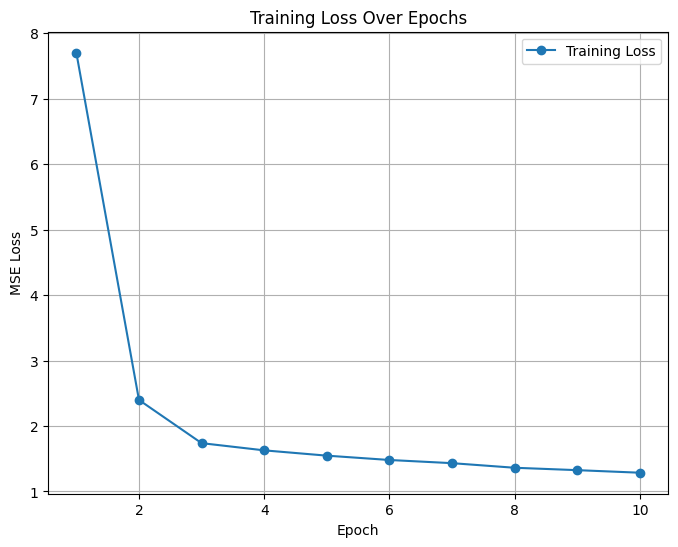

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(results_ncf['Continuous'][2])+1), results_ncf['Continuous'][2], marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 3.4 Model Implementation for Binary Ratings Prediction ##

## 3.4.1 Data Sets and Data Loading for Binary Ratings Prediction ##
RatingDatasetBinary is defined by extending PyTorch’s Dataset class. These wrap our dataframe and return tuples of:
- Encoded user ID (as index)
- Encoded item ID (as index)
- Corresponding label (float)


In [ ]:
class RatingDatasetBinary(Dataset):
    def __init__(self, dataframe):
        self.users = torch.tensor(dataframe['user'].values, dtype=torch.long)
        self.items = torch.tensor(dataframe['item'].values, dtype=torch.long)
        self.labels = torch.tensor(dataframe['label_binary'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

train_dataset_ncf_binary = RatingDatasetBinary(df_train_ncf)
test_dataset_ncf_binary = RatingDatasetBinary(df_test_ncf)

### CREATE DATA LOADERS ###
train_loader_ncf_bin = DataLoader(train_dataset_ncf_binary, batch_size = 512, shuffle = True)
test_loader_ncf_bin = DataLoader(test_dataset_ncf_binary, batch_size = 512, shuffle = False)

## 3.4.2 Training and Evaluation for Binary Ratings Prediction

We define a training function specifically for binary ratings prediction using the NCF model. The function uses **BCELoss** for binary classification, combined with the **Adam optimizer** for efficient training.

### Training Process:
- Iterates over multiple epochs.
- For each batch:
  - Moves data to the device.
  - Computes predictions using the model.
  - Applies **sigmoid** to obtain probabilities.
  - Calculates loss and updates model weights.
- Tracks and records training loss per epoch.

### Evaluation:
- After each epoch, the model is evaluated on both training and test data using the `evaluate_model` function.
- Key metrics include:
  - **Loss, RMSE, Accuracy, Precision@K, Recall@K, F1@K, Hit Rate@K, NDCG@K**
- Results are stored in structured DataFrames for better visualization and comparison.

### Output:
- Displays metrics after each epoch, including formatted accuracy and top-K metrics as percentages.
- Saves the trained model checkpoint for later use.

In [ ]:
def train_binary(model, train_loader, test_loader, device, epochs=10, k=10, threshold=0.5, save_path="binary_model.pt", num_items=None):
    """
    Train the NCF model for binary classification using BCELoss.
    It collects evaluation metrics for each epoch (for both train and test),
    including loss, RMSE, Accuracy, Precision@k, Recall@k, F1@k, Hit Rate@k, and NDCG@k.

    Parameters:
      model: The NCF model.
      train_loader: DataLoader for training.
      test_loader: DataLoader for testing.
      device: Torch device.
      epochs: Number of training epochs.
      k: Cutoff for top-k evaluation metrics.
      threshold: Threshold to convert continuous outputs to binary (default 0.5).
      save_path: Path to save the trained model.
      num_items: (Optional) For padding in NDCG calculation.

    Returns:
      A dictionary containing final training losses, the last epoch’s metrics for train and test,
      and separate metrics tables (as pandas DataFrames) for training and testing.
    """
    import torch.optim as optim
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    train_metrics_list = []
    test_metrics_list = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for users, items, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            users, items, labels = users.to(device), items.to(device), labels.to(device)
            optimizer.zero_grad()
            # Get predictions and apply sigmoid to get probabilities
            preds = torch.sigmoid(model(users, items))
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate on train set and test set using the evaluation function for binary task.
        train_metrics = evaluate_model(model, train_loader, device, k=k, threshold=threshold, task='binary')
        test_metrics = evaluate_model(model, test_loader, device, k=k, threshold=threshold, task='binary')

        # Record metrics for table
        train_epoch_dict = {
            "Epoch": epoch+1,
            "Dataset": "Train",
            "Loss": avg_loss,
            "RMSE": train_metrics["rmse"],
            "Accuracy": train_metrics["accuracy"],
            f"Precision@{k}": train_metrics["precision@k"],
            f"Recall@{k}": train_metrics["recall@k"],
            f"F1@{k}": train_metrics["f1@k"],
            f"HR@{k}": train_metrics["hit_rate@k"],
            f"NDCG@{k}": train_metrics["ndcg@k"]
        }
        test_epoch_dict = {
            "Epoch": epoch+1,
            "Dataset": "Test",
            "RMSE": test_metrics["rmse"],
            "Accuracy": test_metrics["accuracy"],
            f"Precision@{k}": test_metrics["precision@k"],
            f"Recall@{k}": test_metrics["recall@k"],
            f"F1@{k}": test_metrics["f1@k"],
            f"HR@{k}": test_metrics["hit_rate@k"],
            f"NDCG@{k}": test_metrics["ndcg@k"]
        }
        train_metrics_list.append(train_epoch_dict)
        test_metrics_list.append(test_epoch_dict)

    # Save the model checkpoint
    torch.save(model.state_dict(), save_path)

    # Create separate DataFrames for training and testing metrics
    df_train_metrics = pd.DataFrame(train_metrics_list)
    df_test_metrics = pd.DataFrame(test_metrics_list)

    # Convert percentage metrics to percentages (multiply by 100) and round to 3 decimals
    for col in ["Accuracy", f"Precision@{k}", f"Recall@{k}", f"F1@{k}", f"HR@{k}"]:
        df_train_metrics[col] = (df_train_metrics[col] * 100).round(3).astype(str) + '%'
        df_test_metrics[col]  = (df_test_metrics[col] * 100).round(3).astype(str) + '%'

    # Sort each table by Epoch
    df_train_metrics = df_train_metrics.sort_values("Epoch")
    df_test_metrics = df_test_metrics.sort_values("Epoch")

    print("\nFinal Training Evaluation Metrics (per epoch):")
    print(df_train_metrics.to_string(index=False))

    print("\nFinal Testing Evaluation Metrics (per epoch):")
    print(df_test_metrics.to_string(index=False))

    return train_metrics, test_metrics, train_losses, {"train": df_train_metrics, "test": df_test_metrics}

### Training ###
model_bin = NCFModel(num_users, num_items).to(device)

results_ncf['Binary'] = train_binary(model_bin, train_loader_ncf_bin, test_loader_ncf_bin,
                                      device, epochs=10, k=10, threshold=0.5, num_items=num_items)


Epoch 10 Training: 100%|█████████████████████████| 70/70 [00:00<00:00, 201.52it/s]



Final Training Evaluation Metrics (per epoch):
 Epoch Dataset     Loss     RMSE Accuracy Precision@10 Recall@10   F1@10   HR@10  NDCG@10
     1   Train 0.684755 0.803712  63.416%      88.733%   74.974% 65.064% 98.957% 0.747328
     2   Train 0.647688 0.784911  66.838%      85.604%   68.006% 61.696% 97.914% 0.780754
     3   Train 0.622311 0.768269  68.914%      85.529%   66.447% 61.163% 98.361% 0.799316
     4   Train 0.600408 0.752281  71.202%      85.186%   65.012% 60.839%  98.51% 0.816519
     5   Train 0.581373 0.739577  72.718%      82.727%   61.293% 58.122% 97.317% 0.832024
     6   Train 0.563361 0.726035  74.172%      86.155%   64.664% 61.244% 98.808% 0.845790
     7   Train 0.545199 0.715543  75.096%      85.171%   62.401% 60.097% 98.212% 0.854583
     8   Train 0.531891 0.702397  76.407%      85.469%   62.042% 60.277% 97.914% 0.864622
     9   Train 0.517207 0.693517  77.158%      84.829%    62.02% 59.747% 98.063% 0.875945
    10   Train 0.504999 0.679211   78.76%      84.82

## 3.4.3 Training Loss Plot

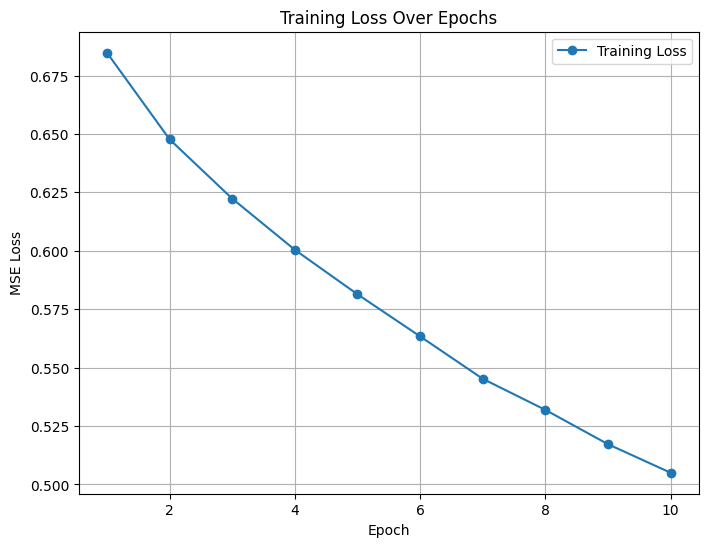

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(results_ncf['Binary'][2])+1), results_ncf['Binary'][2], marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## 3.5 Model Evaluation (Testing and Training) ##

## 3.5.1 Evaluation Metrics for NCF in Predicting Continuous Rating ##

In [ ]:
# Unpack the returned values (assuming your train_binary function returns a tuple)
train_metrics_con, test_metrics_con, train_losses_con, metrics_tables_con = results_ncf['Continuous']

# Extract the last row (final epoch) from each DataFrame
final_train_metrics = metrics_tables_con["train"].iloc[-1:]
final_test_metrics  = metrics_tables_con["test"].iloc[-1:]

# Combine them into a single table (with two rows: one for Train and one for Test)
combined_final_metrics = pd.concat([final_train_metrics, final_test_metrics], ignore_index=True)

# Select only the desired columns
cols_to_show = ["Epoch", "Dataset", "Accuracy", "Precision@10", "Recall@10", "F1@10", "NDCG@10"]
combined_final_metrics = combined_final_metrics[cols_to_show]

print("Final Evaluation Metrics (Last Epoch):")
display(combined_final_metrics)

Final Evaluation Metrics (Last Epoch):


,Epoch,Dataset,Accuracy,Precision@10,Recall@10,F1@10,NDCG@10
0,10,Train,58.721%,44.232%,22.289%,24.734%,0.805487
1,10,Test,57.396%,15.276%,23.807%,15.476%,0.833500


## 3.5.2 Evaluation Metrics for NCF in Predicting Continuous Rating ##

In [ ]:
# Unpack the returned values (assuming your train_binary function returns a tuple)
train_metrics_bin, test_metrics_bin, train_losses_bin, metrics_tables_bin = results_ncf['Binary']

# Extract the last row (final epoch) from each DataFrame
final_train_metrics = metrics_tables_bin["train"].iloc[-1:]
final_test_metrics  = metrics_tables_bin["test"].iloc[-1:]

# Combine them into a single table (with two rows: one for Train and one for Test)
combined_final_metrics = pd.concat([final_train_metrics, final_test_metrics], ignore_index=True)

# Select only the desired columns
cols_to_show = ["Epoch", "Dataset", "Accuracy", "Precision@10", "Recall@10", "F1@10", "NDCG@10"]
combined_final_metrics = combined_final_metrics[cols_to_show]

print("Final Evaluation Metrics (Last Epoch):")
display(combined_final_metrics)

Final Evaluation Metrics (Last Epoch):


,Epoch,Dataset,Accuracy,Precision@10,Recall@10,F1@10,NDCG@10
0,10,Train,78.76%,84.829%,61.16%,59.472%,0.887133
1,10,Test,65.9%,49.151%,92.81%,55.009%,0.751418


## 3.6 Movies Recommendations vs Ground Truth ###

## 3.6.1 Recommendation for Continuous Rating Prediction ##

In [ ]:
# Choose 3 Random User
random_users = np.random.choice(df_test_ncf['user'].unique(), size=3, replace=False)

for user in random_users:
    recs = recommend_top_k(model_con, user, device, df_movies_and_keywords, ratings_df_ncf, df_train_ncf, N=10, item_encoder=item_encoder)
    gt_titles = get_ground_truth_titles(user, df_test_ncf, df_movies_and_keywords, item_encoder)

    print(f"User {user}:")
    print("Ground Truth Titles:", gt_titles)
    print("Top 5 Recommendations:")
    recs_df = pd.DataFrame(recs, columns=["Movie ID", "Title", "Score"])
    display(recs_df)
    print("\n")

User 517:
Ground Truth Titles: ['Indiana Jones and the Temple of Doom', 'Me, Myself & Irene', 'Finding Forrester', 'Forrest Gump', 'Predator 2', 'Land of Plenty', 'Le temps qui reste', 'Sleepless in Seattle', 'Heathers', 'The Butterfly Effect', 'Populärmusik från Vittula', 'Rocky IV', 'Monsoon Wedding', "La passion de Jeanne d'Arc", 'Sweet Sixteen', 'Sommersby', 'Jurassic Park', "Miller's Crossing", 'Halbe Treppe', 'Secret Window', "Dave Chappelle's Block Party", 'Back to the Future Part II', '怪獣総進撃', 'The Conversation', 'Pane e Tulipani', 'Pacific Heights', 'La belle et la bête', 'Rocky V', 'Blood Diamond', 'Knallhart', 'Uncle Buck', 'Light of Day', "What's Eating Gilbert Grape", 'Houseboat', 'Vidas secas', 'Roustabout', '綠草地', "L'arrivée d'un train en gare de La Ciotat", 'Rocky III', 'Armageddon', '28 Weeks Later', 'The Discovery of Heaven', 'Two Weeks Notice', 'Abraham', 'Transamerica', 'The Hours', 'The Perfect Storm', 'Belle Époque', '20,000 Leagues Under the Sea', 'The Golden Com

,Movie ID,Title,Score
0,1213,The Talented Mr. Ripley,4.957780
1,750,Murder She Said,4.801404
2,7085,Winnetou III,4.787754
3,50162,964 Pinocchio,4.728627
4,235,Stand by Me,4.664058
5,71700,Repeaters,4.640073
6,74727,Long Pigs,4.532221
7,858,Sleepless in Seattle,4.529342
8,77,Memento,4.510979
9,4688,Across the Universe,4.473417




User 74:
Ground Truth Titles: ['The Million Dollar Hotel', 'Visions of Europe', 'A Brief History of Time', 'Bridge to Terabithia', "Miller's Crossing", '...Più forte ragazzi!', 'El orfanato', 'Halbe Treppe', 'Frau im Mond', 'The Glass House', 'Notes on a Scandal', 'Breaking and Entering', 'Mission: Impossible II', 'At Risk']
Top 5 Recommendations:


,Movie ID,Title,Score
0,318,The Million Dollar Hotel,4.308144
1,2010,殯の森,4.268019
2,2324,Local Color,4.262651
3,7840,"10,000 BC",4.260498
4,1444,Junebug,4.239910
5,57243,Les Femmes du 6ème étage,4.235151
6,31445,Beyond Tomorrow,4.232675
7,2788,Reality Bites,4.210662
8,1968,Fools Rush In,4.199516
9,775,Le Voyage dans la Lune,4.194277




User 436:
Ground Truth Titles: ['Die Ehe der Maria Braun', 'Licence to Kill', 'Some Like It Hot', 'The Last Samurai']
Top 5 Recommendations:


,Movie ID,Title,Score
0,778,Les Vacances de Monsieur Hulot,4.831657
1,858,Sleepless in Seattle,4.646921
2,2324,Local Color,4.570387
3,26242,Park Row,4.508199
4,47714,Il ladro di bambini,4.489652
5,535,Flashdance,4.480864
6,1938,Angel Face,4.448547
7,953,Madagascar,4.432062
8,475,Bonnie and Clyde,4.426540
9,111,Scarface,4.380581


## 3.6.2 Recommendations for Binary Prediction ##

In [ ]:
# Choose 3 Random User
random_users = np.random.choice(df_test_ncf['user'].unique(), size=3, replace=False)

for user in random_users:
    recs = recommend_top_k(model_bin, user, device, df_movies_and_keywords, ratings_df_ncf, df_train_ncf, N=10, item_encoder=item_encoder)
    gt_titles = get_ground_truth_titles(user, df_test_ncf, df_movies_and_keywords, item_encoder)

    print(f"User {user}:")
    print("Ground Truth Titles:", gt_titles)
    print("Top 10 Recommendations:")
    recs_df = pd.DataFrame(recs, columns=["Movie ID", "Title", "Score"])
    display(recs_df)
    print("\n")

User 277:
Ground Truth Titles: ['Cars', 'The Mummy Returns', 'Meet Me in St. Louis', 'The Pink Panther', 'The Man with the Golden Arm', 'Far from the Madding Crowd', 'Prime']
Top 10 Recommendations:


,Movie ID,Title,Score
0,38499,The Howling: New Moon Rising,4.019639
1,3469,Far from the Madding Crowd,3.955876
2,31427,野火,3.320551
3,957,Spaceballs,3.314401
4,34326,仁義なき戦い,3.255181
5,5558,Le Fantôme de la liberté,3.251577
6,26865,X: The Unknown,3.231527
7,1254,"Je vais bien, ne t'en fais pas",3.226599
8,565,The Ring,3.184767
9,318,The Million Dollar Hotel,3.166123




User 291:
Ground Truth Titles: ['American Graffiti', 'The King of Comedy', '隠し砦の三悪人', 'Torrente 3: El protector', 'La Cité des Enfants Perdus', 'An Unfinished Life', 'The Last Castle', "Knockin' on Heaven's Door", 'Four Rooms', 'Revolutionary Road', 'The Bourne Identity', 'Qui a tué Bambi ?', '5 Card Stud', 'バトル・ロワイアル', 'La Mort en direct', 'The Golden Compass', 'Light of Day', 'La Môme', 'We Own the Night', 'Love Actually', 'Cat on a Hot Tin Roof', 'Underworld', 'Syriana', 'Yesterday', 'Bad Boys II', 'Muxmäuschenstill', 'Boogie Nights', 'New York Doll', 'Ober']
Top 10 Recommendations:


,Movie ID,Title,Score
0,8916,Antz,3.554017
1,91690,Les neiges du Kilimandjaro,3.225380
2,534,Terminator Salvation,3.145415
3,4704,At Long Last Love,3.101908
4,88950,'Gator Bait,3.039997
5,5147,The Lost Continent,3.010350
6,6183,Barfuß,2.933720
7,2973,Аэлита,2.862259
8,3102,Мой сводный брат Франкенштейн,2.791364
9,30867,Scott Walker: 30 Century Man,2.770087




User 586:
Ground Truth Titles: ["Wayne's World 2", 'Les Vacances de Monsieur Hulot', 'Miffo', 'Forces of Nature', 'Enchanted', 'Ballo a tre passi', 'Baise-moi', '도쿄!', 'The Killing', 'Cold Mountain', 'The Bank Dick', 'The Reaping', 'Once in a Lifetime: The Extraordinary Story of the New York Cosmos', 'The Mexican', 'Street Kings', 'The Man I Love', 'Reservation Road', 'Big Trouble in Little China', 'Schwerkraft', 'Barda', 'Felidae', '三枪拍案惊奇', 'Nothing Like the Holidays', 'Broken Blossoms', 'The Man with the Golden Arm', 'El espíritu de la colmena', 'Cars', 'Fever Pitch', 'Swept from the Sea', 'La Cité des Enfants Perdus', 'The History Boys', 'شکارچی', 'The Enforcer', 'Deadlier Than the Male', 'ラブ&ポップ', 'Bella Bettien', 'The Delivery', 'End of the World']
Top 10 Recommendations:


,Movie ID,Title,Score
0,1957,Enough,4.100586
1,34528,人間の條件 第３部望郷篇／第４部戦雲篇,3.524311
2,2690,Irma la Douce,3.523955
3,3077,Son of Frankenstein,3.514997
4,957,Spaceballs,3.456679
5,565,The Ring,3.431248
6,3001,How to Steal a Million,3.289952
7,32825,Wild in the Country,3.107035
8,1247,The Good Shepherd,3.088732
9,2897,Around the World in Eighty Days,3.048652


# 4. Neural Matrix Factorisation (NeuMF) #
NeuMF is an another variant of NCF that combines both linear and non-linear modeling of user–item interactions by fusing two complementary approaches:

<b> Generalized Matrix Factorization (GMF): </b>
- Captures the linear part of the user–item interaction.
- Uses element-wise multiplication of user and item embeddings.
- Provides a signal similar to traditional matrix factorization methods.
<b>Multi-Layer Perceptron (MLP): </b>
- Captures non-linear, complex interactions between user and item latent features.
- Uses concatenated embeddings processed through multiple dense layers with non-linear activations.

<b> Fusion Mechanism: </b>
- The outputs of the GMF and MLP components are combined.
- A final prediction layer merges these signals to produce the recommendation score.

## 4.1 Dataset and DataLoader ##

RatingDataset is defined by extending PyTorch’s Dataset class. These wrap our dataframe and return tuples of:
- Encoded user ID (as index)
- Encoded item ID (as index)
- Corresponding label (float)

In [ ]:
class RatingDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user'].values, dtype = torch.long)
        self.items = torch.tensor(df['item'].values, dtype = torch.long)
        self.labels = torch.tensor(df['label'].values, dtype = torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

train_dataset_neumf = RatingDataset(df_train_ncf)
test_dataset_neumf  = RatingDataset(df_test_ncf)

train_loader_neumf = DataLoader(train_dataset_neumf, batch_size = 512, shuffle = True)
test_loader_neumf  = DataLoader(test_dataset_neumf, batch_size = 512, shuffle = False)

## 4.2 NeuMF Model Definition ##

We define a composite model class `NeuMF(nn.Module)` that integrates both Generalized Matrix Factorization (GMF) and a Multi-Layer Perceptron (MLP) to capture both linear and non-linear user–item interactions.

**GMF Component:**
- **User Embedding (GMF):**  
  - `self.user_embedding_gmf` learns a dense representation for each user with an embedding dimension (default: 16).
- **Item Embedding (GMF):**  
  - `self.item_embedding_gmf` learns a dense representation for each item with the same dimension.
- **Element-wise Interaction:**  
  - The GMF user and item embeddings are combined through element-wise multiplication to capture linear interactions.

**MLP Component:**
- **User Embedding (MLP):**  
  - `self.user_embedding_mlp` learns a dense representation for each user with an embedding dimension 32
- **Item Embedding (MLP):**  
  - `self.item_embedding_mlp` learns a dense representation for each item with the same dimension.
- **Concatenation and MLP Layers:**  
  - The MLP embeddings for user and item are concatenated to form a vector of size 64.  
  - This vector is passed through several fully connected layers:
    1. **Linear(64 → 128):** Followed by ReLU activation and Dropout (p=0.3) for regularization.
    2. **Linear(128 → 64):** Followed by ReLU activation.
    3. **Linear(64 → 32):** Followed by ReLU activation.

**Fusion and Output:**
- **Fusion:**  
  - The outputs of the GMF (vector of size 16) and the MLP (vector of size 32) are concatenated.
- **Output Layer:**  
  - A final linear layer transforms the fused vector into a single scalar prediction.

This architecture leverages the complementary strengths of GMF and MLP components, enabling the model to learn complex, non-linear interactions while also capturing linear patterns. This makes NeuMF well-suited for tasks such as rating prediction and recommendation ranking.

In [ ]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim_gmf=16, embedding_dim_mlp=32):
        super(NeuMF, self).__init__()

        self.user_embedding_gmf = nn.Embedding(num_users, embedding_dim_gmf)
        self.item_embedding_gmf = nn.Embedding(num_items, embedding_dim_gmf)

        self.user_embedding_mlp = nn.Embedding(num_users, embedding_dim_mlp)
        self.item_embedding_mlp = nn.Embedding(num_items, embedding_dim_mlp)

        self.mlp_layers = nn.Sequential(
            nn.Linear(embedding_dim_mlp * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )

        self.output_layer = nn.Linear(embedding_dim_gmf + 32, 1)

    def forward(self, user, item):
        gmf_user = self.user_embedding_gmf(user)
        gmf_item = self.item_embedding_gmf(item)
        gmf_vector = gmf_user * gmf_item

        mlp_user = self.user_embedding_mlp(user)
        mlp_item = self.item_embedding_mlp(item)
        mlp_vector = torch.cat([mlp_user, mlp_item], dim=-1)
        mlp_output = self.mlp_layers(mlp_vector)

        combined = torch.cat([gmf_vector, mlp_output], dim=-1)
        prediction = self.output_layer(combined).squeeze()
        return prediction

## 4.3 NeuMF Training and Evaluation

The training function for the NeuMF model follows a structured approach to optimize model performance. The model is trained using **Mean Squared Error (MSE) Loss** and evaluated using various metrics.

### Training Loop
- For each epoch:
  - The model is set to training mode.
  - User, item, and rating data are loaded in batches.
  - The predicted ratings are computed and compared to the ground truth using MSE Loss.
  - The loss is backpropagated, and optimizer updates are applied.
  - The average loss for the epoch is recorded.

### Evaluation
- After each epoch, the model is evaluated on both the training and test sets using the `evaluate_model` function.
- Metrics collected include:
  - **Loss:** Mean Squared Error.
  - **RMSE:** Root Mean Squared Error.
  - **Accuracy:** Proportion of correct predictions.
  - **Precision@K:** Fraction of relevant items in the top-K list.
  - **Recall@K:** Fraction of relevant items retrieved among all relevant items.
  - **F1@K:** Harmonic mean of precision and recall.
  - **HR@K (Hit Rate):** At least one relevant item appears in the top-K list.
  - **NDCG@K (Normalized Discounted Cumulative Gain):** Accounts for the ranking quality of relevant items.

In [ ]:
def train_neumf(model, train_loader, test_loader, df_test, device, epochs=10, tolerance=0.5, k=10, threshold=4, save_path="neumf_model.pt"):
    import torch.optim as optim
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses = []
    train_metrics_list = []
    test_metrics_list = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for users, items, ratings in tqdm(train_loader, desc=f'Epoch {epoch+1} Training'):
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            optimizer.zero_grad()
            outputs = model(users, items)  # predicted ratings
            loss = criterion(outputs, ratings)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate on both train and test sets using your evaluate_model function
        train_metrics = evaluate_model(model, train_loader, device, k=k, threshold=threshold, task="regression")
        test_metrics  = evaluate_model(model, test_loader, device, k=k, threshold=threshold, task="regression")

        # Record per-epoch metrics into dictionaries
        train_epoch_dict = {
            "Epoch": epoch + 1,
            "Dataset": "Train",
            "Loss": avg_loss,
            "RMSE": train_metrics["rmse"],
            "Accuracy": train_metrics["accuracy"],
            f"Precision@{k}": train_metrics["precision@k"],
            f"Recall@{k}": train_metrics["recall@k"],
            f"F1@{k}": train_metrics["f1@k"],
            f"HR@{k}": train_metrics["hit_rate@k"],
            f"NDCG@{k}": train_metrics["ndcg@k"]
        }
        test_epoch_dict = {
            "Epoch": epoch + 1,
            "Dataset": "Test",
            "RMSE": test_metrics["rmse"],
            "Accuracy": test_metrics["accuracy"],
            f"Precision@{k}": test_metrics["precision@k"],
            f"Recall@{k}": test_metrics["recall@k"],
            f"F1@{k}": test_metrics["f1@k"],
            f"HR@{k}": test_metrics["hit_rate@k"],
            f"NDCG@{k}": test_metrics["ndcg@k"]
        }
        train_metrics_list.append(train_epoch_dict)
        test_metrics_list.append(test_epoch_dict)

        # print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f} | Train RMSE: {train_metrics['rmse']:.3f}, Acc: {train_metrics['accuracy']*100:.2f}%, NDCG@{k}: {train_metrics['ndcg@k']:.3f}")
        # print(f"           Test RMSE: {test_metrics['rmse']:.3f}, Acc: {test_metrics['accuracy']*100:.2f}%, NDCG@{k}: {test_metrics['ndcg@k']:.3f}\n")

    # Save the model checkpoint
    torch.save(model.state_dict(), save_path)

    # Create separate DataFrames for training and testing metrics
    df_train_metrics = pd.DataFrame(train_metrics_list)
    df_test_metrics  = pd.DataFrame(test_metrics_list)

    # Format percentage metrics: Accuracy, Precision@k, Recall@k, F1@k, HR@k
    for col in ["Accuracy", f"Precision@{k}", f"Recall@{k}", f"F1@{k}", f"HR@{k}"]:
        df_train_metrics[col] = (df_train_metrics[col] * 100).round(3).astype(str) + '%'
        df_test_metrics[col]  = (df_test_metrics[col] * 100).round(3).astype(str) + '%'

    df_train_metrics = df_train_metrics.sort_values("Epoch")
    df_test_metrics  = df_test_metrics.sort_values("Epoch")

    print("\nFinal Training Evaluation Metrics (per epoch):")
    print(df_train_metrics.to_string(index=False))

    print("\nFinal Testing Evaluation Metrics (per epoch):")
    print(df_test_metrics.to_string(index=False))

    # Pack the final metrics into a dictionary
    metrics_tables = {"train": df_train_metrics, "test": df_test_metrics}
    final_metrics = {
        "train_losses": train_losses,
        "last_train_metrics": train_metrics,
        "last_test_metrics": test_metrics,
        "metrics_table": metrics_tables
    }
    return final_metrics

### Model Execution ###

model_neumf = NeuMF(num_users, num_items).to(device)
final_metrics_neumf = train_neumf(model_neumf, train_loader_ncf_con, test_loader_ncf_con, df_test_ncf, device, epochs=10, tolerance=0.5)

Epoch 10 Training: 100%|█████████████████████████| 70/70 [00:00<00:00, 186.97it/s]



Final Training Evaluation Metrics (per epoch):
 Epoch Dataset     Loss     RMSE Accuracy Precision@10 Recall@10   F1@10   HR@10  NDCG@10
     1   Train 4.508754 1.090412  52.251%      56.244%   37.844% 35.444% 88.376% 0.649028
     2   Train 1.242405 1.022122  51.349%      33.294%   18.779%   18.9% 71.088% 0.688020
     3   Train 1.137596 0.985174  53.203%      35.946%    19.48% 20.322% 72.876% 0.719949
     4   Train 1.062169 0.960609  53.959%      36.349%   19.739% 20.728% 75.559% 0.739006
     5   Train 1.014504 0.944246  54.284%      33.666%   17.275% 18.773% 72.727% 0.752326
     6   Train 0.976342 0.925280  56.629%      42.712%    22.65% 24.572% 80.626% 0.759315
     7   Train 0.955389 0.912538  57.906%      45.544%   25.256% 26.767% 82.861% 0.764895
     8   Train 0.926411 0.908484  55.805%      36.602%   18.251% 20.326% 73.025% 0.769673
     9   Train 0.911053 0.899849  56.197%      37.526%   18.107% 20.659% 73.174% 0.775569
    10   Train 0.884603 0.891607  57.155%      39.80

## 4.3.1 Training Loss Plot ##

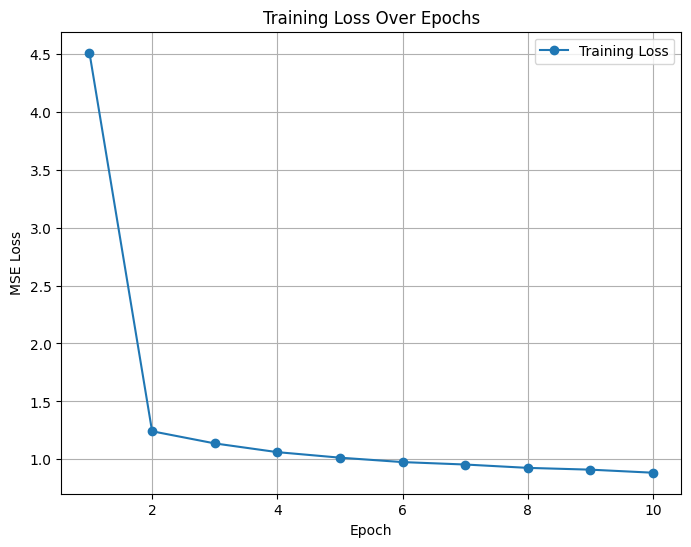

In [ ]:
# Plot the training loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(final_metrics_neumf['train_losses'])+1), final_metrics_neumf['train_losses'], marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## 4.4 NeuMF Evaluation Metrics

In [ ]:
import pandas as pd

# Extract final train and test metrics from results_hybrid_gated.
train_metrics = final_metrics_neumf['last_train_metrics']
test_metrics  = final_metrics_neumf['last_test_metrics']

# Select only the desired keys.
selected_keys = ["accuracy", "precision@k", "recall@k", "f1@k", "ndcg@k"]

# Create dictionaries with only the selected keys.
train_selected = {key: train_metrics[key] for key in selected_keys}
test_selected  = {key: test_metrics[key] for key in selected_keys}

# Convert to percentages and round to 3 decimals.
for key in selected_keys:
    train_selected[key] = round(train_selected[key] * 100, 3)
    test_selected[key]  = round(test_selected[key] * 100, 3)

# Add a column to indicate the dataset.
train_selected["Dataset"] = "Train"
test_selected["Dataset"]  = "Test"

# Create a DataFrame combining both dictionaries.
final_df = pd.DataFrame([train_selected, test_selected])

# Reorder columns.
final_df_gated = final_df[["Dataset", "accuracy", "precision@k", "recall@k", "f1@k", "ndcg@k"]]

print(final_df_gated.to_string(index=False))

Dataset  accuracy  precision@k  recall@k   f1@k  ndcg@k
  Train    57.155       39.806    19.868 22.421  78.095
   Test    58.390       14.307    22.838 14.544  83.926


## 4.5 Recommendations vs Ground Truth

In [ ]:
# Choose 3 random users from the test set.
random_users = np.random.choice(df_test_ncf['user'].unique(), size=3, replace=False)

for user in random_users:
    recs = recommend_top_k(model_neumf, user, device, df_movies_and_keywords, ratings_df_ncf, df_train_ncf, N=10, item_encoder=item_encoder)
    gt_titles = get_ground_truth_titles(user, df_test_ncf, df_movies_and_keywords, item_encoder)

    print(f"User {user}:")
    print("Ground Truth Titles:", gt_titles)
    print("Top 10 Recommendations:")
    recs_df = pd.DataFrame(recs, columns=["Movie ID", "Title", "Score"])
    display(recs_df)
    print("\n")

User 457:
Ground Truth Titles: ['Big Fish', 'The Man with the Golden Arm', 'Psycho', 'Romeo + Juliet', 'Point Break', 'My Name Is Bruce', 'Twin Peaks: Fire Walk with Me', 'High Noon']
Top 10 Recommendations:


,Movie ID,Title,Score
0,31903,History Is Made at Night,4.461308
1,243,High Fidelity,4.398209
2,26010,Long nga,4.397930
3,5961,Fanny och Alexander,4.381446
4,668,On Her Majesty's Secret Service,4.376159
5,65216,Bloody Cartoons,4.238011
6,3035,Frankenstein,4.227073
7,621,Grease,4.206977
8,53999,My Super Psycho Sweet 16: Part 2,4.203910
9,86000,오직 그대만,4.175924




User 45:
Ground Truth Titles: ["L'Ours", 'La Chienne', 'In Time']
Top 10 Recommendations:


,Movie ID,Title,Score
0,1537,Changing Lanes,4.702763
1,5961,Fanny och Alexander,4.650233
2,31903,History Is Made at Night,4.632632
3,86000,오직 그대만,4.618484
4,668,On Her Majesty's Secret Service,4.611977
5,4267,Préparez vos mouchoirs,4.567165
6,1945,Nell,4.488971
7,56715,Just Visiting,4.461953
8,293,A River Runs Through It,4.450737
9,7944,Shine a Light,4.436508




User 631:
Ground Truth Titles: ['...Più forte ragazzi!', 'Bang Boom Bang - Ein todsicheres Ding', 'License to Wed', 'Poltergeist']
Top 10 Recommendations:


,Movie ID,Title,Score
0,26010,Long nga,4.336854
1,243,High Fidelity,4.254635
2,858,Sleepless in Seattle,4.253086
3,1537,Changing Lanes,4.249781
4,926,Galaxy Quest,4.225606
5,31903,History Is Made at Night,4.224328
6,86000,오직 그대만,4.224084
7,5961,Fanny och Alexander,4.198331
8,5137,Sky Captain and the World of Tomorrow,4.186131
9,53999,My Super Psycho Sweet 16: Part 2,4.179456


## 5. Hybrid NeuMF with Movies Features via Concatenation

In this model, additional movie features (like textual representations, release year, runtime category, popularity, and voting statistics) are integrated into the NeuMF framework.

### Approach:
- The movie features are concatenated with the user and item embeddings before being processed by the MLP layers.
- This approach allows the model to learn both collaborative filtering patterns and content-based relationships.

### Implementation:
- The movie features are passed through a linear transformation to reduce dimensionality.
- The transformed movie features are concatenated with the user and item embeddings.
- The resulting combined vector is processed through the MLP layers, capturing complex interactions between user, item, and movie features.

This hybrid approach enhances the model's ability to generalize by incorporating content-based information, making it particularly useful for dealing with sparse user-item interaction data.

## 5.1 Data Preparation

To incorporate movie features into the Hybrid NeuMF model, we first prepare the features by combining multiple attributes into a single vector.

- **Encoding Runtime Category:**  
  We use a `LabelEncoder` to convert the runtime category (e.g., `Short`, `Medium`, `Long`) into integers.

- **Combining Movie Features:**  
  We define a function to concatenate various movie-related attributes into a single feature vector:
  - **Textual Representation (BERT Embedding):** 384 dimensions.
  - **Years Since Release:** 1 dimension.
  - **One-Hot Encoded Runtime Category:** 3 dimensions.
  - **Numerical Features (Normalized):** 3 dimensions (vote average, vote count, popularity).  
  - Total concatenated vector size: **391 dimensions**.

- **Storing Combined Features:**  
  The resulting feature vectors are stored as a new column `movie_features` in the DataFrame.  
  We also create a dictionary that maps each movie ID to its corresponding feature vector for efficient lookups during model training and prediction.

In [ ]:
le = LabelEncoder()
df_movies_and_keywords['runtime_category_encoded'] = le.fit_transform(df_movies_and_keywords['runtime_category'])

def combine_movie_features(row):
    # Textual representation (384-dim)
    text_repr = np.array(row['bert_embedding'])

    # years_since_released as a 1-dim vector
    years_since = np.array([row['years_since_release']])

    # One-hot encode runtime_category (3-dim)
    runtime = np.zeros(3)
    runtime[int(row['runtime_category_encoded'])] = 1

    # Other numerical features (each 1-dim): count_average_norn, vote_count_norm, popularity_norm
    other_feats = np.array([row['vote_average_norm'], row['vote_count_norm'], row['popularity_norm']])

    # Concatenate all parts: total dimension = 384 + 1 + 3 + 3 = 391.
    return np.concatenate([text_repr, years_since, runtime, other_feats])

# Create a new column with the combined movie features
df_movies_and_keywords['movie_features'] = df_movies_and_keywords.apply(combine_movie_features, axis=1)

# Build a dictionary mapping movieId to its movie_features vector.
movie_features_dict = df_movies_and_keywords.set_index('id')['movie_features'].to_dict()

## 5.2 Dataset Class with Movies Features


We define a custom PyTorch `Dataset` class to accommodate the additional movie features for the Hybrid NeuMF model.

- **Input Structure:**  
  - User IDs, Item IDs, Ratings, and the combined movie feature vectors.  
  - The movie features are retrieved from a precomputed dictionary.

- **Data Handling:**  
  - Each item in the dataset returns the user ID, item ID, rating, and the corresponding movie features.  
  - Missing features are filled with a zero vector of length 391.


In [ ]:
class RatingDatasetWithFeatures(Dataset):
    def __init__(self, ratings_df, movie_features_dict):
        """
        ratings_df: DataFrame with columns 'user', 'item', 'label', and 'movieId'
        movie_features_dict: Dictionary mapping movieId to its combined feature vector.
        """
        self.users = torch.tensor(ratings_df['user'].values, dtype=torch.long)
        self.items = torch.tensor(ratings_df['item'].values, dtype=torch.long)
        self.labels = torch.tensor(ratings_df['label'].values, dtype=torch.float32)
        # Retrieve movie features using the original movieId.
        self.movie_features = []
        for movie_id in ratings_df['movieId']:
            feat = movie_features_dict.get(movie_id, np.zeros(391))
            self.movie_features.append(feat)
        self.movie_features = torch.tensor(np.array(self.movie_features), dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx], self.movie_features[idx]

# Create Dataset instances.
train_dataset = RatingDatasetWithFeatures(df_train_ncf, movie_features_dict)
test_dataset  = RatingDatasetWithFeatures(df_test_ncf, movie_features_dict)

# Create DataLoaders.
batch_size = 512
train_loader_hybrid = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_hybrid  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 5.3 Evaluation Function

The evaluation function calculates several performance metrics for the Hybrid NeuMF model:

- **Loss Calculation:**  
  - Uses **MSE Loss** for regression and **BCE Loss** for binary tasks.  
  - The loss is averaged over all samples.

- **Accuracy Calculation:**  
  - For regression, the threshold (e.g., 4) determines if a prediction is accurate.    
  - Accuracy is calculated as the proportion of correct predictions.


In [ ]:
def evaluate_model(model, data_loader, device, k=10, threshold=4, task="regression"):
    """
    Evaluate the model on a data loader.

    Returns a dictionary containing:
      - loss: Average loss (MSE).
      - rmse: Root MSE.
      - accuracy: Binary accuracy (using threshold to binarize).
      - precision@k, recall@k, f1@k, hit_rate@k, ndcg@k: Recommendation metrics.
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []
    all_users = []

    if task == "regression":
        criterion = nn.MSELoss(reduction='sum')
    else:
        criterion = nn.BCELoss(reduction='sum')

    with torch.no_grad():
        for batch in data_loader:
            # For our hybrid model, the batch contains 4 elements.
            users, items, labels, movie_feats = batch
            users, items, labels, movie_feats = users.to(device), items.to(device), labels.to(device), movie_feats.to(device)
            outputs = model(users, items, movie_feats)
            if task == "binary":
                outputs = torch.sigmoid(outputs)
            batch_size = users.size(0)
            total_samples += batch_size
            total_loss += criterion(outputs, labels).item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_users.extend(users.cpu().numpy())

    loss_avg = total_loss / total_samples
    rmse = np.sqrt(loss_avg)

    if task == "regression":
        bin_preds = (np.array(all_preds) >= threshold).astype(int)
        bin_labels = (np.array(all_labels) >= threshold).astype(int)
    else:
        bin_preds = (np.array(all_preds) >= 0.5).astype(int)
        bin_labels = np.array(all_labels).astype(int)

    overall_acc = np.mean(bin_preds == bin_labels)

    # Compute recommendation metrics using evaluate_recommendations (assumed defined elsewhere)
    precision, recall, f1, hit_rate, ndcg = evaluate_recommendations(
        np.array(all_users), np.array(all_preds), np.array(all_labels), k=k, threshold=threshold
    )

    metrics = {
        'loss': loss_avg,
        'rmse': rmse,
        'accuracy': overall_acc,
        'precision@k': precision,
        'recall@k': recall,
        'f1@k': f1,
        'hit_rate@k': hit_rate,
        'ndcg@k': ndcg
    }
    return metrics

## 5.4 Hybrid NeuMF Model Definition

We define a composite model class `HybridNCFModel(nn.Module)` that integrates both **collaborative filtering embeddings** and **movie features** to enhance prediction accuracy.

### CF Embeddings:
- **User Embedding:**  
  - `self.user_embedding` learns a dense representation for each user with an embedding dimension (default: 32).
- **Item Embedding:**  
  - `self.item_embedding` learns a dense representation for each item with the same dimension.

### Movie Feature Embedding:
- **Movie Feature Transformation:**  
  - `self.movie_feature_fc` reduces the dimensionality of the movie feature vector (default: 391) to a lower dimension (64).  
  - Uses a fully connected linear layer followed by a ReLU activation.  
  - This transformation helps in integrating heterogeneous movie features into the model.

### MLP Branch:
- **Concatenation of Embeddings:**  
  - The concatenated vector consists of:
    - User embedding (32).
    - Item embedding (32).
    - Transformed movie feature embedding (64).
  - Total size: **32 + 32 + 64 = 128**.  
- **MLP Layers:**  
  - The combined vector is passed through the following layers:
    1. **Linear(128 → 128):** Followed by ReLU activation.
    2. **Linear(128 → 64):** Followed by ReLU activation and Dropout (p=0.5).

### GMF Branch:
- **Element-wise Interaction:**  
  - The GMF user and item embeddings are combined through **element-wise multiplication** to capture **linear interactions**.

### Fusion and Output:
- **Fusion:**  
  - The outputs of the GMF (vector of size 32) and the MLP (vector of size 64) are concatenated.  
- **Output Layer:**  
  - A final linear layer transforms the fused vector into a single scalar prediction.

This architecture leverages both **collaborative filtering embeddings** and **content-based movie features**, allowing it to model complex, non-linear user–item interactions while incorporating rich movie metadata.

In [ ]:
class HybridNCFModel(nn.Module):
    def __init__(self, num_users, num_items,
                 cf_emb_dim = 32,
                 movie_feature_dim = 391,    # 384 (bert_embeddings) + 1 + 3 + 3 = 391
                 movie_feature_emb_dim = 64):  # Changed from 16 to 128
        """
        Hybrid NCF Model that incorporates movie features.

        Parameters:
          num_users: Number of unique users.
          num_items: Number of unique movies.
          cf_emb_dim: Dimension for user and item CF embeddings.
          movie_feature_dim: Dimension of the combined movie feature vector (e.g., 391).
          movie_feature_emb_dim: Output dimension for the movie feature embedding (now 128).
        """
        super(HybridNCFModel, self).__init__()
        # CF Embeddings
        self.user_embedding = nn.Embedding(num_users, cf_emb_dim)
        self.item_embedding = nn.Embedding(num_items, cf_emb_dim)

        # Transform movie features to a lower-dimensional embedding.
        self.movie_feature_fc = nn.Linear(movie_feature_dim, movie_feature_emb_dim)

        # MLP branch input dimension: user_emb + item_emb + movie_feature_emb
        mlp_input_dim = cf_emb_dim + cf_emb_dim + movie_feature_emb_dim
        self.fc1 = nn.Linear(mlp_input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5)

        # Final layer: combine the GMF branch and the MLP branch.
        # GMF branch output: cf_emb_dim (32)
        # MLP branch output: 64
        self.final_layer = nn.Linear(cf_emb_dim + 64, 1)

    def forward(self, user, item, movie_features):
        # GMF branch
        user_emb = self.user_embedding(user)      # shape: [batch, cf_emb_dim]
        item_emb = self.item_embedding(item)        # shape: [batch, cf_emb_dim]
        gmf_out = user_emb * item_emb               # shape: [batch, cf_emb_dim]

        # MLP branch:
        movie_feat_emb = F.relu(self.movie_feature_fc(movie_features))  # shape: [batch, movie_feature_emb_dim]
        mlp_input = torch.cat([user_emb, item_emb, movie_feat_emb], dim=1)  # shape: [batch, cf_emb_dim*2 + movie_feature_emb_dim]
        x = F.relu(self.fc1(mlp_input))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        mlp_out = x  # shape: [batch, 64]

        # Combine GMF and MLP branches.
        combined = torch.cat([gmf_out, mlp_out], dim=1)  # shape: [batch, cf_emb_dim + 64]
        prediction = self.final_layer(combined).squeeze()
        return prediction

## 5.5 Training and Evaluating Hybrid NeuMF Model

We train the Hybrid NeuMF model using the **Adam optimizer** and **MSELoss**. During each epoch:
- The model is trained on the training data.
- Predictions are generated, and loss is computed and backpropagated.
- The model is evaluated on both training and testing datasets.

Metrics (like Accuracy, RMSE, Precision@K, Recall@K, F1@K, Hit Rate@K, and NDCG@K) are calculated for each epoch. The final metrics are saved, and the trained model is stored for later use.

In [ ]:
def train_hybrid(model, train_loader, test_loader, device, epochs=10, k=10, threshold=4, save_path="hybrid_model.pt"):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_metrics_list = []
    test_metrics_list = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} Training'):
            users, items, labels, movie_feats = batch
            users, items, labels, movie_feats = users.to(device), items.to(device), labels.to(device), movie_feats.to(device)
            optimizer.zero_grad()
            preds = model(users, items, movie_feats)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate on train and test sets
        train_metrics = evaluate_model(model, train_loader, device, k=k, threshold=threshold, task="regression")
        test_metrics = evaluate_model(model, test_loader, device, k=k, threshold=threshold, task="regression")

        # Record metrics for table
        train_epoch_dict = {
            "Epoch": epoch+1,
            "Dataset": "Train",
            "Loss": avg_loss,
            "RMSE": train_metrics["rmse"],
            "Accuracy": train_metrics["accuracy"],
            f"Precision@{k}": train_metrics["precision@k"],
            f"Recall@{k}": train_metrics["recall@k"],
            f"F1@{k}": train_metrics["f1@k"],
            f"HR@{k}": train_metrics["hit_rate@k"],
            f"NDCG@{k}": train_metrics["ndcg@k"]
        }
        test_epoch_dict = {
            "Epoch": epoch+1,
            "Dataset": "Test",
            "RMSE": test_metrics["rmse"],
            "Accuracy": test_metrics["accuracy"],
            f"Precision@{k}": test_metrics["precision@k"],
            f"Recall@{k}": test_metrics["recall@k"],
            f"F1@{k}": test_metrics["f1@k"],
            f"HR@{k}": test_metrics["hit_rate@k"],
            f"NDCG@{k}": test_metrics["ndcg@k"]
        }
        train_metrics_list.append(train_epoch_dict)
        test_metrics_list.append(test_epoch_dict)

        # print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.2f} | Train RMSE: {train_metrics['rmse']:.3f}, Acc: {train_metrics['accuracy']*100:.2f}%, NDCG@{k}: {train_metrics['ndcg@k']:.3f}")
        # print(f"           Test RMSE: {test_metrics['rmse']:.3f}, Acc: {test_metrics['accuracy']*100:.2f}%, NDCG@{k}: {test_metrics['ndcg@k']:.3f}\n")

    torch.save(model.state_dict(), save_path)

    # Create separate DataFrames for training and testing metrics
    df_train_metrics = pd.DataFrame(train_metrics_list)
    df_test_metrics = pd.DataFrame(test_metrics_list)

    # Format percentage metrics
    for col in ["Accuracy", f"Precision@{k}", f"Recall@{k}", f"F1@{k}", f"HR@{k}"]:
        df_train_metrics[col] = (df_train_metrics[col] * 100).round(3).astype(str) + '%'
        df_test_metrics[col] = (df_test_metrics[col] * 100).round(3).astype(str) + '%'

    df_train_metrics = df_train_metrics.sort_values("Epoch")
    df_test_metrics = df_test_metrics.sort_values("Epoch")

    print("\nFinal Training Evaluation Metrics (per epoch):")
    print(df_train_metrics.to_string(index=False))

    print("\nFinal Testing Evaluation Metrics (per epoch):")
    print(df_test_metrics.to_string(index=False))

    metrics_tables = {"train": df_train_metrics, "test": df_test_metrics}
    final_metrics = {
        "train_losses": train_losses,
        "last_train_metrics": train_metrics,
        "last_test_metrics": test_metrics,
        "metrics_table": metrics_tables
    }
    return final_metrics

## 5.6 Hybrid NeuMF Model Execution ##

In [ ]:
# Initialize the hybrid model.
hybrid_model = HybridNCFModel(num_users, num_items, cf_emb_dim=32, movie_feature_dim=391, movie_feature_emb_dim=64).to(device)

# Train the hybrid model.
results_hybrid = train_hybrid(hybrid_model, train_loader_hybrid, test_loader_hybrid, device, epochs=15, k=10, threshold=4, save_path="hybrid_model.pt")

Epoch 15 Training: 100%|█████████████████████████| 70/70 [00:00<00:00, 123.74it/s]



Final Training Evaluation Metrics (per epoch):
 Epoch Dataset     Loss     RMSE Accuracy Precision@10 Recall@10   F1@10   HR@10  NDCG@10
     1   Train 4.362075 1.092790   48.71%      25.529%   12.111% 13.378% 63.487% 0.645919
     2   Train 1.518428 1.028221  49.217%      15.037%    7.652%  8.301% 40.387% 0.698833
     3   Train 1.383252 0.995927  50.102%      19.106%     9.61% 10.593% 54.993% 0.736783
     4   Train 1.316217 0.965482  52.788%      30.566%   15.615% 17.361% 71.386% 0.751027
     5   Train 1.283065 0.947591  54.041%      35.827%   18.486% 20.319% 77.943% 0.758224
     6   Train 1.240905 0.942542  52.858%      28.838%   13.624% 15.654% 61.997% 0.765824
     7   Train 1.208186 0.915445  56.382%      40.954%   20.803% 23.281% 79.881% 0.771814
     8   Train 1.187544 0.900275  57.836%      44.814%   23.204%   26.0%  81.52% 0.778949
     9   Train 1.154087 0.894304  56.892%      42.146%   21.338% 24.128% 77.645% 0.782287
    10   Train 1.139826 0.888162  56.962%      40.47

## 5.6.1 Training Loss Plot ##

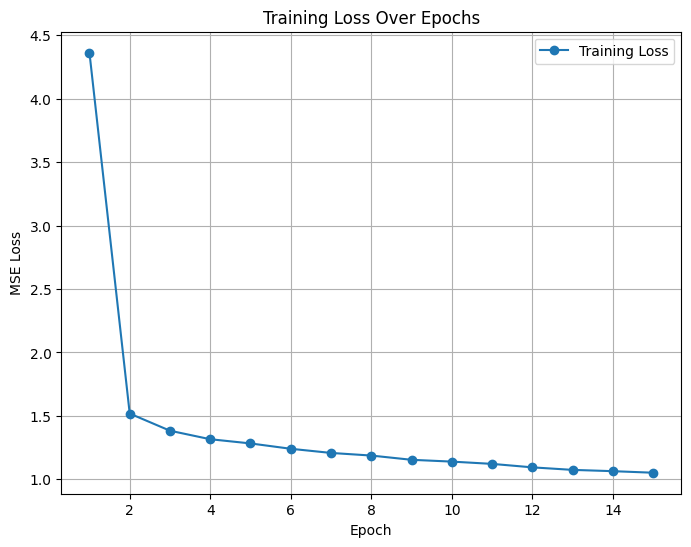

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 15+1), results_hybrid['train_losses'], marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## 5.7 Hybrid NeuMF Model Evaluation

In [ ]:
import pandas as pd

# Extract final train and test metrics from results_hybrid.
train_metrics = results_hybrid['last_train_metrics']
test_metrics  = results_hybrid['last_test_metrics']

# Select only the desired keys.
selected_keys = ["accuracy", "precision@k", "recall@k", "f1@k", "ndcg@k"]

# Create dictionaries with only the selected keys.
train_selected = {key: train_metrics[key] for key in selected_keys}
test_selected  = {key: test_metrics[key] for key in selected_keys}

# Convert to percentages and round to 3 decimals.
for key in selected_keys:
    train_selected[key] = round(train_selected[key] * 100, 3)
    test_selected[key]  = round(test_selected[key] * 100, 3)

# Add a column to indicate the dataset.
train_selected["Dataset"] = "Train"
test_selected["Dataset"]  = "Test"

# Create a DataFrame combining both dictionaries.
final_df = pd.DataFrame([train_selected, test_selected])

# Reorder columns.
final_df = final_df[["Dataset", "accuracy", "precision@k", "recall@k", "f1@k", "ndcg@k"]]

print(final_df.to_string(index=False))

Dataset  accuracy  precision@k  recall@k   f1@k  ndcg@k
  Train    59.643       46.885    23.791 26.902  80.300
   Test    59.525       16.826    26.662 17.361  84.576


# 6. Hybrid NeuMF with Movies Features via Gated Fusion

The Hybrid NeuMF with Gated Fusion model enhances the basic hybrid approach by incorporating **gating mechanisms** to dynamically combine the GMF, MLP, and movie feature representations.

### Gated Fusion Mechanism:
- Instead of directly concatenating the GMF and MLP outputs with movie features, this model learns **gated weights**.
- The gate values determine the **relative importance** of the GMF and MLP outputs in the final prediction.
- This dynamic fusion allows the model to **adaptively balance** between collaborative filtering (GMF) and feature-rich representations (MLP and movie features).

### Implementation:
- Separate **embedding layers** for users and items, as in the standard NeuMF.
- **Movie feature transformation** using a fully connected layer to reduce dimensionality.
- **Gating network** to learn the weights for combining GMF, MLP, and movie features.
- The final output layer predicts the user-item interaction score.

This model is expected to perform better than simple concatenation due to its ability to **adaptively weigh different input components**.

## 6.1 Data Loaders ##

In [ ]:
### Create DataLoaders ###
batch_size = 512
train_loader_hybrid_gated = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_hybrid_gated  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 6.2 Hybrid NeuMF Model Definition with Gated Fusion

We define a composite model class `GatedHybridNCFModel(nn.Module)` that integrates **Generalized Matrix Factorization (GMF)** and **Multi-Layer Perceptron (MLP)** with **Gated Fusion**. This model aims to dynamically balance the influence of **collaborative filtering (GMF)** and **movie features (MLP)**.

**GMF Component:**
- **User Embedding (GMF):**  
  - Learns a dense vector for each user with an embedding dimension of 32.  
- **Item Embedding (GMF):**  
  - Learns a dense vector for each movie with the same embedding dimension.  
- **Element-wise Interaction:**  
  - The GMF user and item embeddings are combined through element-wise multiplication.  

**MLP Component:**
- **Movie Feature Embedding:**  
  - Transforms the high-dimensional movie feature vector (391) to a lower dimension (64).  
- **Concatenation and MLP Layers:**  
  - User, item, and movie feature embeddings are concatenated.  
  - The combined vector is passed through two fully connected layers:  
    1. **Linear(128 → 64):** ReLU activation and Dropout (p=0.5) for regularization.  
    2. **Linear(64 → 32):** ReLU activation.  

**Gating Mechanism:**
- **Gating Layer:**  
  - Learns a scalar weight from the movie feature embedding.  
  - Uses a sigmoid activation to scale the MLP output, dynamically balancing between CF and movie features.  

**Fusion and Output:**
- **Combining GMF and Gated MLP:**  
  - The scaled MLP output is combined with the GMF output through concatenation.  
- **Output Layer:**  
  - A final linear layer outputs the predicted interaction score.  

This architecture leverages the **gated fusion mechanism** to adaptively balance the importance of collaborative filtering and content-based features, making it more robust in capturing complex interactions.

In [ ]:
class GatedHybridNCFModel(nn.Module):
    def __init__(self, num_users, num_items, cf_emb_dim=32, movie_feature_dim=391, movie_feature_emb_dim=64):
        super(GatedHybridNCFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, cf_emb_dim)
        self.item_embedding = nn.Embedding(num_items, cf_emb_dim)
        self.movie_feature_fc = nn.Linear(movie_feature_dim, movie_feature_emb_dim)

        # MLP branch for collaborative filtering + content fusion.
        mlp_input_dim = cf_emb_dim * 2 + movie_feature_emb_dim
        self.fc1 = nn.Linear(mlp_input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5)

        # Gating layer to learn weight for movie features.
        self.gate = nn.Linear(movie_feature_emb_dim, 1)

        # Final layer: combine GMF branch and gated MLP branch.
        self.final_layer = nn.Linear(cf_emb_dim + 64, 1)

    def forward(self, user, item, movie_features):
        # CF branch (GMF)
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        gmf_out = user_emb * item_emb  # elementwise product

        # Movie features embedding
        movie_feat_emb = F.relu(self.movie_feature_fc(movie_features))

        # MLP branch: concatenate user, item, and movie feature embeddings
        mlp_input = torch.cat([user_emb, item_emb, movie_feat_emb], dim=1)
        x = F.relu(self.fc1(mlp_input))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Gating mechanism: compute a weight for movie features.
        gate_weight = torch.sigmoid(self.gate(movie_feat_emb))  # shape: [batch, 1]
        # For example, scale the MLP output by the gate weight:
        gated_mlp = gate_weight * x

        # Combine the GMF branch with the gated MLP branch.
        combined = torch.cat([gmf_out, gated_mlp], dim=1)
        prediction = self.final_layer(combined).squeeze()
        return prediction

## 6.3 Hybrid NeuMF Model Execution

In [ ]:
# Initialize the hybrid model.
hybrid_model_gated = GatedHybridNCFModel(num_users, num_items, cf_emb_dim=32, movie_feature_dim=391, movie_feature_emb_dim=64).to(device)

# Train the hybrid model.
results_hybrid_gated = train_hybrid(hybrid_model_gated, train_loader_hybrid_gated, test_loader_hybrid_gated, device, epochs=15, k=10, threshold=4, save_path="hybrid_model.pt")

Epoch 15 Training: 100%|█████████████████████████| 70/70 [00:00<00:00, 161.61it/s]



Final Training Evaluation Metrics (per epoch):
 Epoch Dataset     Loss     RMSE Accuracy Precision@10 Recall@10   F1@10   HR@10  NDCG@10
     1   Train 4.980708 1.097141  49.578%      33.264%   16.324% 17.548% 72.727% 0.652662
     2   Train 1.492510 1.021241  49.903%      22.176%    9.692% 11.092% 58.867% 0.694169
     3   Train 1.378537 0.992322  50.637%      22.653%    10.47% 11.824% 61.699% 0.733760
     4   Train 1.324810 0.971762  51.534%      25.663%    12.32% 13.655%  66.17% 0.743679
     5   Train 1.280497 0.943410   55.62%      39.508%   20.156% 22.203% 75.708% 0.759880
     6   Train 1.259967 0.931421  55.452%      36.379%   18.294% 20.372% 73.174% 0.764542
     7   Train 1.216412 0.912377    58.2%      45.514%   23.752% 26.102% 81.073% 0.774533
     8   Train 1.185649 0.898599  61.847%       55.32%   30.906% 33.264%  87.63% 0.781560
     9   Train 1.167588 0.891635   59.27%      44.769%   22.928% 25.517% 78.241% 0.782118
    10   Train 1.142769 0.904116  55.643%      34.73

## 6.3.1 Training Loss Plot

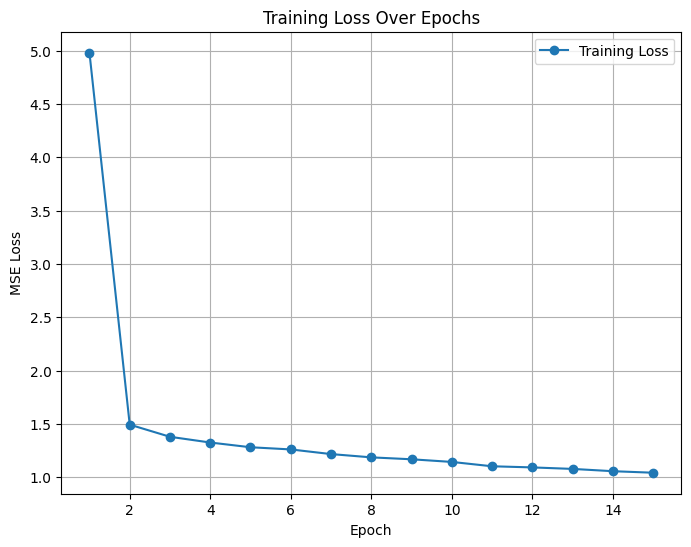

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 15+1), results_hybrid_gated['train_losses'], marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## 6.4 Hybrid NeuMF via Gated Fusion Model Evaluation Metrics

In [ ]:
import pandas as pd

# Extract final train and test metrics from results_hybrid_gated.
train_metrics = results_hybrid_gated['last_train_metrics']
test_metrics  = results_hybrid_gated['last_test_metrics']

# Select only the desired keys.
selected_keys = ["accuracy", "precision@k", "recall@k", "f1@k", "ndcg@k"]

# Create dictionaries with only the selected keys.
train_selected = {key: train_metrics[key] for key in selected_keys}
test_selected  = {key: test_metrics[key] for key in selected_keys}

# Convert to percentages and round to 3 decimals.
for key in selected_keys:
    train_selected[key] = round(train_selected[key] * 100, 3)
    test_selected[key]  = round(test_selected[key] * 100, 3)

# Add a column to indicate the dataset.
train_selected["Dataset"] = "Train"
test_selected["Dataset"]  = "Test"

# Create a DataFrame combining both dictionaries.
final_df = pd.DataFrame([train_selected, test_selected])

# Reorder columns.
final_df_gated = final_df[["Dataset", "accuracy", "precision@k", "recall@k", "f1@k", "ndcg@k"]]

print(final_df_gated.to_string(index=False))

Dataset  accuracy  precision@k  recall@k   f1@k  ndcg@k
  Train    62.525       52.563    27.298 30.778  80.541
   Test    61.059       20.984    32.876 21.621  84.039
